# FACE DETECTION

In [1]:
#Requirement
#!pip install keras==2.2.4

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

---

In [4]:
def resize_image(im, max_size=768):
    if np.max(im.shape) > max_size:
        ratio = max_size / np.max(im.shape)
        print(f"Resize image to ({str(int(im.shape[1]*ratio))}, {str(int(im.shape[0]*ratio))}).")
        return cv2.resize(im, (0,0), fx=ratio, fy=ratio)
    return im

Resize image to (713, 768).


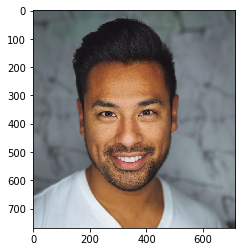

In [55]:
#Read Image
im = cv2.imread("images/artis.jpg")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)
plt.show()

---
# 1. Face detection

Face detection dengan menggunakan S3FD dan FAN.

In [56]:
from models.detector import face_detector

In [57]:
warnings.filterwarnings("ignore")
fd = face_detector.FaceAlignmentDetector(
    lmd_weights_path="./models/detector/FAN/2DFAN-4_keras.h5"# 2DFAN-4_keras.h5, 2DFAN-1_keras.h5
)

## Detect faces

In [58]:
bboxes = fd.detect_face(im, with_landmarks=False)

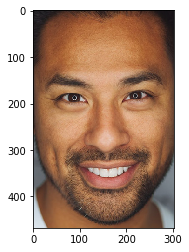

In [59]:
assert len(bboxes) > 0, "No face detected."

#Menampilkan wajah-wajah yang terdeteksi
for bbox in bboxes:
    x0, y0, x1, y1, score = bbox 
    x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])
    plt.imshow(im[x0:x1, y0:y1, :])
    plt.show()

---
# 2. Face Segmetation

Face Segmentation menggunakan model BiSeNet.

In [60]:
from models.parser import face_parser

warnings.filterwarnings("ignore")
prs = face_parser.FaceParser()

## Parse without face deteciton

In [61]:
out = prs.parse_face(im)

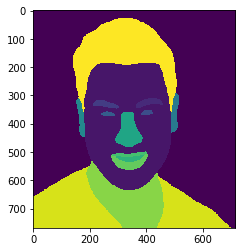

In [92]:
plt.imshow(out[0])
plt.savefig("output/segmentation.jpg")

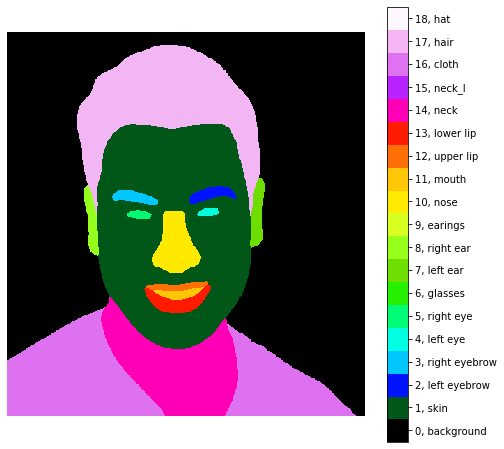

In [63]:
# Show parsing result with annotations

from utils.visualize import show_parsing_with_annos
show_parsing_with_annos(out[0])

## Segmentation with face detection

Parsing network has its best performance on single face (even better if aligned).

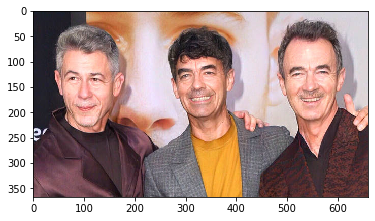

In [74]:
from models.detector import face_detector

file = "images/bertiga.jpg"

im = cv2.imread(file)[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

In [75]:
# Set detector into FaceParser
def segmentation(file, with_detection=False):
    im = cv2.imread(file)[..., ::-1]
    im = resize_image(im) 
    try:
        fd
    except:
        fd = face_detector.FaceAlignmentDetector()

    prs.set_detector(fd)
    out = prs.parse_face(im, with_detection=True)
    num_faces = len(out)
    for i in range(num_faces):
        try:
            plt.subplot(1, num_faces, i+1)
            plt.imshow(out[i])
        except:
            pass
# prs.remove_detector()

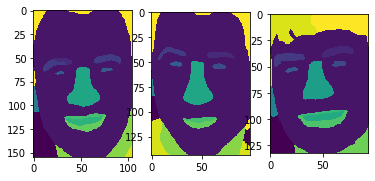

In [78]:
segmentation(file)

# Segmentation Stream Video 

In [99]:
import cv2
import numpy as np
import time

file_name = "images/My Video.mp4"

def SegmentationVideo(file):
    cap = cv2.VideoCapture(file)

    time.sleep(2.0)
    count = 0
    start_time = time.time()
    while True:
        count+=1
        __, frame = cap.read()
        if frame is None:
            break

        out = prs.parse_face(frame)
        img = cv2.cvtColor(out[0], cv2.COLOR_BGR2RGB)
        cv2.imshow("Frame", img)
#         cv2.imwrite("output/fa"+str(count)+".jpg", frame)
        key = cv2.waitKey(1) & 0xFF
         # if the 'q' key is pressed, stop the loop
        key = cv2.waitKey(1)
        if key == 27:
            break

    cv2.destroyAllWindows()
    print("Execution time video : %s ms ---" % ((time.time() - start_time)*1000))
    print("Execution time per frame : %s ms ---" % ((time.time() - start_time)*1000/count))


In [100]:
SegmentationVideo(file_name)

Execution time video : 46481.600761413574 ms ---
Execution time per frame : 566.860978196307 ms ---
